In [26]:
# Importar Bibliotecas

# EDA
import pandas as pd
import numpy as np

# Visualização
import plotly.express as px
import matplotlib.pyplot as plt

# Configuração
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.printoptions(suppress=True, precision=3)

# Machine Learning
from lightgbm import LGBMClassifier, early_stopping, plot_tree, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, \
                            ConfusionMatrixDisplay, log_loss

# Otimização Bayesiana
from bayes_opt import BayesianOptimization

### Carregar Dados

In [3]:
df_vinhos = pd.read_csv('wine_data.csv')

In [4]:
# Visualizar Estrutura
df_vinhos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         21000 non-null  float64
 1   volatile_acidity      21000 non-null  float64
 2   citric_acid           21000 non-null  float64
 3   residual_sugar        21000 non-null  float64
 4   chlorides             21000 non-null  float64
 5   free_sulfur_dioxide   21000 non-null  float64
 6   total_sulfur_dioxide  21000 non-null  float64
 7   density               21000 non-null  float64
 8   pH                    21000 non-null  float64
 9   sulphates             21000 non-null  float64
 10  alcohol               21000 non-null  float64
 11  quality               21000 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 1.9 MB


In [6]:
# Primeiros Registros
df_vinhos.head(10)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0           11.6             0.580         0.66            2.20      0.074   
1           10.4             0.610         0.49            2.10      0.200   
2            7.4             1.185         0.00            4.25      0.097   
3           10.4             0.440         0.42            1.50      0.145   
4            8.3             1.020         0.02            3.40      0.084   
5            7.6             1.580         0.00            2.10      0.137   
6            6.8             0.815         0.00            1.20      0.267   
7            7.3             0.980         0.05            2.10      0.061   
8            7.1             0.875         0.05            5.70      0.082   
9            6.7             0.760         0.02            1.80      0.078   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 10.0                  47.0  1.00080  3.25       0.57   
1                  5.0                  16.0  0.99940  3.16       0.63   
2                  5.0                  14.0  0.99660  3.63       0.54   
3                 34.0                  48.0  0.99832  3.38       0.86   
4                  6.0                  11.0  0.99892  3.48       0.49   
5                  5.0                   9.0  0.99476  3.50       0.40   
6                 16.0                  29.0  0.99471  3.32       0.51   
7                 20.0                  49.0  0.99705  3.31       0.55   
8                  3.0                  14.0  0.99808  3.40       0.52   
9                  6.0                  12.0  0.99600  3.55       0.63   

   alcohol  quality  
0     9.00        3  
1     8.40        3  
2    10.70        3  
3     9.90        3  
4    11.00        3  
5    10.90        3  
6     9.80        3  
7     9.70        3  
8    10.20        3  
9     9.95        3

### EDA

In [7]:
# Distribuição das Variáveis numéricas
numerical_cols = df_vinhos.drop('quality', axis=1).columns

In [11]:
for col in numerical_cols:
    fig = px.histogram(df_vinhos, x=col, nbins=20, title=f'Distribuição de {col}')
    fig.show()

In [13]:
# Visualizar distribuição da variável target

df_count = df_vinhos['quality'].value_counts().reset_index()
df_count.columns = ['quality', 'contagem']

fig = px.bar(df_count, x='quality', y='contagem', title='Distribuição da variável Target')
fig.show()

In [14]:
# Analisando relação entre variáveis numéricas e target
for col in numerical_cols:
    fig = px.box(df_vinhos, x='quality', y=col, title=f'Relação entre {col} e quality')
    fig.show()

In [15]:
# Matriz de Correlação
corr = df_vinhos.corr()

# HeatMap da matriz de correlação
fig = px.imshow(corr,
                color_continuous_scale='armyrose',
                title='Matriz de Correlação',
                zmin=-1,
                zmax=1)

fig.update_traces(text=corr, texttemplate='%{text:.2f}', textfont_size=9)
fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

### Preparação dos Dados

In [16]:
# Separer conjunto X e y
X = df_vinhos.drop('quality', axis=1)
y = df_vinhos['quality']

In [17]:
# Dividir em treino, validação e teste
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.5, random_state=51)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=51)

### Trinar Modelo LightGMB usando Otmização Bayesiana

In [18]:
# Definir Grande de hiperparamatros a serem otimizados
grade_hiperparametros = {
    'num_leaves': (10, 100),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'min_data_in_leaf': (5, 50),
    'feature_fraction': (0.5, 0.8)
}

In [19]:
# Criar função para o modelo lightGNM
def lightgbm_evaluete(num_leaves, max_depth, learning_rate, min_data_in_leaf, feature_fraction):
   
    modelo = LGBMClassifier(
        num_leaves=int(num_leaves),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        min_data_in_leaf=int(min_data_in_leaf),
        feature_fraction=feature_fraction,
        n_estimators=100
    )

    # Treinar Modelo com Early Stopping
    modelo.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[early_stopping(5)]
    )

    # Métrica de avaliação
    best_score = modelo.best_score_['valid_0']['multi_logloss']

    return -best_score

In [20]:
# Otimização Bayesiana
optimizer = BayesianOptimization(f=lightgbm_evaluete, pbounds=grade_hiperparametros, random_state=51)
optimizer.maximize(init_points=5, n_iter=2)

|   iter    |  target   | featur... | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.7027194246510657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7027194246510657
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] feature_fraction is set=0.7027194246510657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7027194246510657
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info

In [21]:
# Melhor Combinação de hiperparametros
print('Melhores hiperparâmetros encontrados', optimizer.max)

Melhores hiperparâmetros encontrados {'target': -1.363279629015174, 'params': {'feature_fraction': 0.7263915175522024, 'learning_rate': 0.22132614082794028, 'max_depth': 9.777131264694447, 'min_data_in_leaf': 37.13546279353573, 'num_leaves': 62.412047249516874}}


### Validar Resultados

In [22]:
# Treinar Modelo com os Melhors Hiperparâmetros
best_param = optimizer.max['params']

best_model = LGBMClassifier(
    num_leaves=int(best_param['num_leaves']),
    max_depth=int(best_param['max_depth']),
    learning_rate=best_param['learning_rate'],
    min_data_in_leaf=int(best_param['min_data_in_leaf']),
    feature_fraction=best_param['feature_fraction'],
    n_estimators=100
)

# Treinar Modelo
best_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.7263915175522024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263915175522024
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.7263915175522024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263915175522024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 11
[LightGBM] [Info] Start training from score -1.924149
[LightGBM] [Info] Start training from score -1.937942
[LightGBM] [Info] Start training from score -1.9432

LGBMClassifier(feature_fraction=0.7263915175522024,
               learning_rate=0.22132614082794028, max_depth=9,
               min_data_in_leaf=37, num_leaves=62)

In [23]:
# Fazer Predições
y_pred = best_model.predict(X_test)
y_pred

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.7263915175522024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263915175522024


array([9, 3, 3, ..., 3, 9, 6], dtype=int64)

In [27]:
# Fazer a predições de probabilidades
y_pred_proba = best_model.predict_proba(X_test)
y_pred_proba

[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] feature_fraction is set=0.7263915175522024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263915175522024


array([[1.15935753e-01, 2.16092704e-01, 1.52521753e-02, ...,
        2.46160248e-01, 1.05366087e-01, 2.95446838e-01],
       [5.99394721e-01, 5.03446508e-02, 3.71641190e-02, ...,
        9.11591439e-02, 9.81867236e-02, 1.23641076e-01],
       [4.90917695e-01, 2.27860123e-02, 1.86708338e-03, ...,
        1.20756347e-01, 9.23095525e-02, 2.71046971e-01],
       ...,
       [9.47781064e-01, 1.56366845e-02, 3.44048789e-03, ...,
        4.95464025e-03, 2.36326015e-02, 4.26011156e-03],
       [1.40727255e-01, 6.72271749e-02, 4.31380751e-03, ...,
        4.20364147e-02, 6.77211796e-02, 6.73925696e-01],
       [3.75495974e-05, 6.37582263e-05, 1.96332580e-03, ...,
        2.08301303e-01, 5.26139967e-02, 6.01228157e-06]])

In [29]:
# Relatório de Classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.47      0.54      0.50       741
           4       0.45      0.47      0.46       728
           5       0.61      0.53      0.57       764
           6       0.59      0.62      0.60       748
           7       0.48      0.41      0.44       732
           8       0.51      0.49      0.50       756
           9       0.49      0.54      0.51       781

    accuracy                           0.52      5250
   macro avg       0.52      0.51      0.51      5250
weighted avg       0.52      0.52      0.51      5250



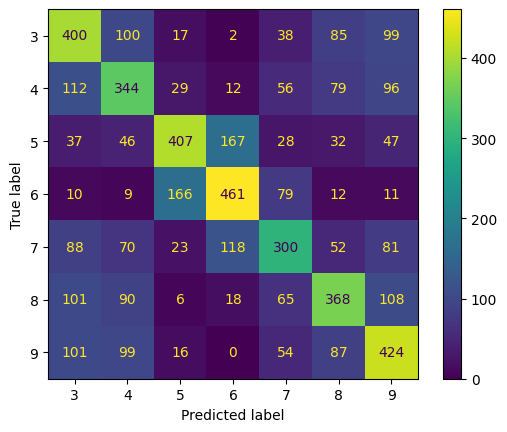

In [30]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=best_model.classes_)
fig.plot()

In [31]:
# Log Loss Geral
log_loss(y_test, y_pred_proba)

1.3719292179850375

### Interpretabilidade


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

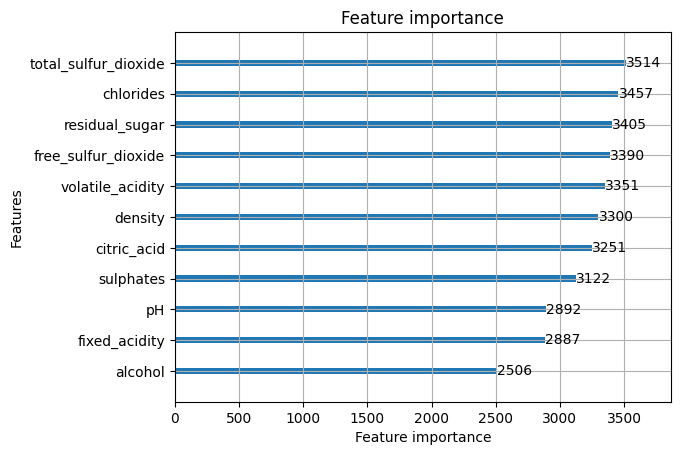

In [32]:
# Importancia das varipaveis
plot_importance(best_model)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

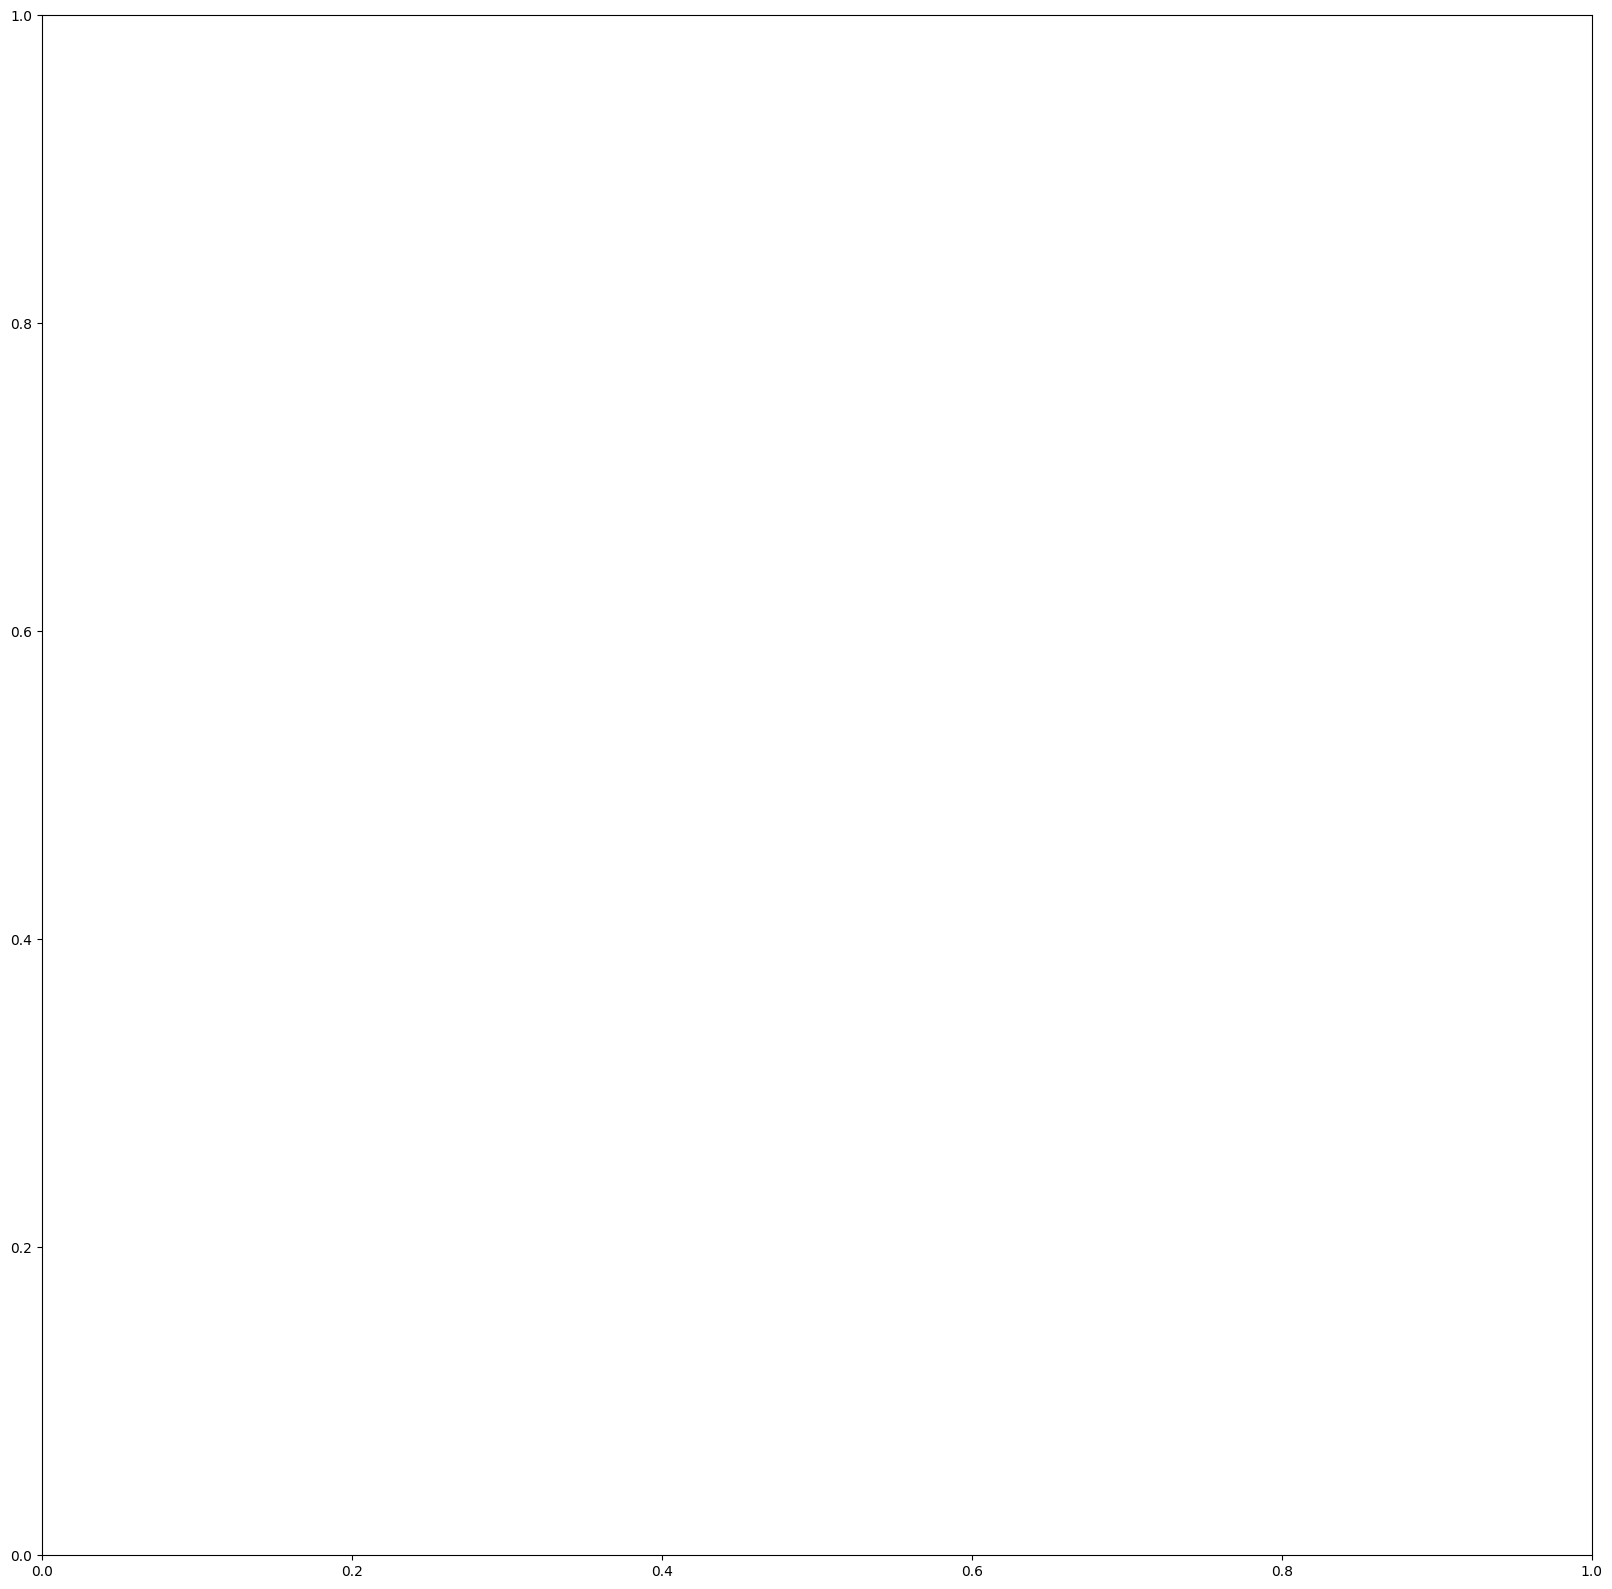

In [35]:
# Visualizar Árvore de Decisão
plot_tree(best_model, figsize=(20, 20))

In [ ]:
,